# Tracking the healing of a scared landscape...
***How can we use remote sensing and weather/climate data to monitor the recovery of vegetation ecosystems after geological resource extraction projects have closed?***

Project group members: Christian Haselwimmer

Project mentors: Nayani Ilangakoon (CU EarthLab), Steve Perkins (Chevron)

In [1]:
# Libraries and configuration that will be used in this blog post
import datetime
from datetime import date
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
import contextily as cx
import folium
import configparser
from IPython.display import YouTubeVideo

from sentinelhub import SHConfig, WcsRequest, MimeType, CRS, BBox, \
    Geometry, CustomUrlParam, FisRequest, DataCollection
from sentinelhub.time_utils import iso_to_datetime, parse_time

# SentinelHub configuration
config = SHConfig()

# SentinelHub instance ID for AWS Europe endpoint
config.instance_id = '*****' # Removed for security

# SentinelHub credentials from the OAuth client
config.sh_client_id = '*****' # Removed for security
config.sh_client_secret = '*****' # Removed for security
config.save()

# Read configuration file
config_ini = configparser.ConfigParser()
config_ini.read('sentinel2_setup.ini')

# SentinelHub configuration
config = SHConfig()
config.instance_id = config_ini['Config']['instance_id'] # Instance ID for the Configuration
config.sh_client_id = config_ini['Config']['sh_client_id'] # Credentials from the OAuth client
config.sh_client_secret = config_ini['Config']['sh_client_secret']
config.save()

# Set working directory
os.chdir(os.path.join('D:/',
                      'McKinley'))

## Demands for geological resources
The earth's population, especially the roughly 20% that live in the most developed countries, have significant demands for geological resources such as hydrocarbons, raw materials, minerals, and metals. Whilst we make strides in efforts to reduce these demands, for example through energy efficiency, closed loop supply chains, and decarbonisation, the projections for global population and development suggest that there will be continuing and increasing needs for geological resources.

## The environmental impact
The extraction of geological resources has an inevitable impact on the environment. Resource projects may have significant physical footprints where major earth-movement tasks are required (e.g. open-cast mining) or large surface facilities need to be constructed. This physical impact may lead to degradation, loss, or destruction of pre-development ecosystems and habitats. Responsible development of geological resources involves careful planning to minimize and mitigate the potential physical environmental impacts (air, water, soil, ecological) and accounting for ecosystem disturbance/loss through offsetting measures.


<img src="img/environmental.jpg" alt="Environmental impacts of geological resource extraction" style="width: 800px;"/>
<center>Examples of the physical environmental impact of geological resource extraction. Left: Kennecott copper mine in Utah (Source: Kennecott). Right: Kern River oil field in Calfornia (Source: Sierra Club)</center>

## Responsible closure
Closing facilities in a responsible way is fundamental to improving the sustainability of geological resource developments. Once a facility has reached the end of its life these sites must be returned to their pre-development or improved ecological condition. The process of retiring assets can include remediation of potential impacts to ecological receptors (e.g. soils and waters), reclamation and earth-movement to return the topography to a natural state, and ecological restoration such as vegetation re-establishment/re-seeding and/or elimination of invasive species.

## Restoring vegetation ecosystems
Vegetation restoration aims to repair the damage caused by land disturbance associated with resource extraction projects. It includes restoring the natural vegetation state and rebuild the soils of disturbed lands through either natural processes (plant succession) or man-made rewilding/reseeding efforts. The success of vegetation restoration efforts requires careful monitoring over many years to ensure that minimum thresholds are met with regards to vegetation cover, species makeup, function, and sustainability.

<img src="img/restoration.jpg" alt="Environmental impacts of geological resource extraction" style="width: 800px;"/>
<center>Example of responsible closure and vegetation restoration. Left: McKinley Mine open-pit coal mining operations. Right: the same location after reclamation and vegetation restoration</center>

## Getting a pulse on the state of vegetation restoration
Monitoring vegetation restoration projects typically requires detailed, time consuming, and in-frequent field surveys. Satellite remote sensing has potential to provide additional information to augment or replace these field methods. The synoptic coverage and cadence of satellite remote sensing could provide a capability for more timely monitoring of key vegetation parameters that when coupled with weather/climate data has potential to be used for restoration planning and decision making. In this project I will use remote sensing and climate data to monitor the trajectory and success of vegetation restoration measures at a specific legacy coal mining site (McKinley Mine) in New Mexico.

There are numerous published studies that have focused on the use of moderate resolution satellite remote sensing data to monitor vegetation restoration such as Reif and Theel (2016), Meroni et al. (2017), Chasmer et al. (2018), Wang et al. (2021); a useful review of the application of remote sensing to mine site restoration monitoring is also presented in McKenna et al. (2020). There are a number of published papers that have used weather data to interpret or build models against remote sensing variables (e.g. NDVI) to interpret vegetation dynamics in semi-arid/rangeland ecosystems; see for example: Wang et al. (2003), Thoma et al. (2016), Copeland et al. (2018), and Zhou et al. (2021). 

## McKinley coal mine, New Mexico
The former McKinley open-pit coal mine is located in Western New Mexico near to the city of Gallup (see map below). This 28,000 acre site was operational up until 2009 (see the video below) after which the site was completely reclaimed and regraded. Currently the site is in various stages of vegetation restoration.

#### Video showing coal mining operations at McKinley Mine

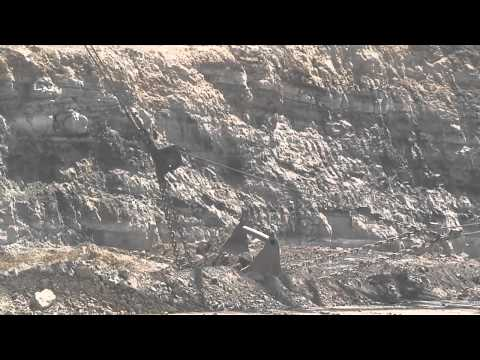

In [2]:
# Embed a video
YouTubeVideo('rBMTTxi7jb0', width=854, height=480)

#### Location map of McKinley Mine

C:\Users\ekqo\Miniconda3\envs\earth-analytics-python\lib\site-packages\contextily\tile.py:353: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  img.transpose(2, 0, 1), transform, "EPSG:3857", t_crs, resampling


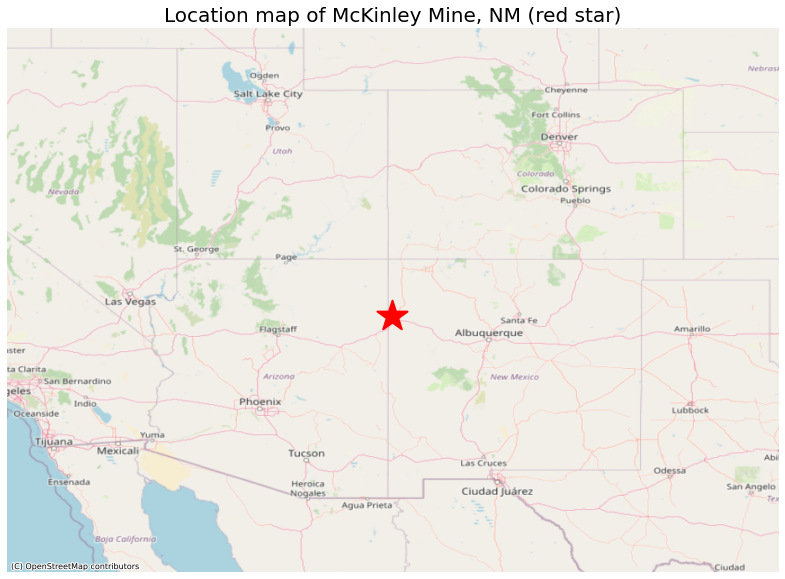

In [3]:
# Import polygon for extent of location map
mckinley_aoi_large_path = os.path.join(
    'vectors', 'mckinley_large_figure_bounds.shp')
mckinley_aoi_large = gpd.read_file(mckinley_aoi_large_path)

# Import point polygon for McKinley Mine location
mckinley_location_path = os.path.join(
    'vectors', 'mckinley_location.shp')
mckinley_location = gpd.read_file(mckinley_location_path)

# Plot location map
fig, (ax) = plt.subplots(1, 1, figsize=(15, 10))

xlim = ([mckinley_aoi_large.total_bounds[0],
         mckinley_aoi_large.total_bounds[2]])
ylim = ([mckinley_aoi_large.total_bounds[1],
         mckinley_aoi_large.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

mckinley_location.plot(ax=ax,
                       color='red',
                       marker='*',
                       markersize=1000,
                       linewidth=2
                       )

cx.add_basemap(ax, crs=mckinley_aoi_large.crs.to_string(),
               source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title(
    "Location map of McKinley Mine, NM (red star)", fontsize=20)

ax.set_axis_off()

## Methods and results
### Overview
The general methods that I will be using for this project include:
- Accessing outlines of different vegetation management and seeding units at McKinley Mine that will be the basis for the remote sensing analysis
- Building a time series of remote sensing vegetation indices from Sentinel 2 and Landsat 8 data for 2013-present
- Extracting a time series of weather/climate data for 2013 to present
- Calculating relevant remote sensing (e.g. max annual NDVI) and weather/climate (e.g annual precipitation) metrics for the different vegetation management and seeding units
- Building statistical models using metrics to understand controlling variables

### Datasources
- Vector datasets will include polygons of vegetation management units and seeding units at McKinley Mine
- Sentinel 2 and Landsat 8 multispectral remote sensing data and time series analyses over the 2013 to current period will be accessed through SentinelHub (https://www.sentinel-hub.com/); the calculation of time series of vegetation indices including NDVI and SAVI will be performed using the Statistical Info Service (FIS) API (https://www.sentinel-hub.com/develop/api/ogc/fis-request/).
- Climate/weather data time series will be retrieved either from aWhere (https://www.awhere.com/) or from the GRIDMET (University of Idaho Gridded Surface Meteorological Dataset) accessible through Google Earth Engine (https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET) 

### Python workflows
#### Open vector data for Vegetation Management Units (VMU's) at McKinley Mine in an interactive map
VMU's represent areas of the mine that have undergone different histories of vegetation restoration measures. The time series of vegetation indices will be calculated for each VMU to account for the different phases of seeding. Let's start by opening and creating visualization of the VMU's.

In [4]:
# Import polygons for Vegetation Management Units (VMU's)
vmu_path = os.path.join('vectors',
                        'mckinley_vmu.shp')
vmu_polys = gpd.read_file(vmu_path)
vmu_polys = vmu_polys.to_crs("EPSG:4326")
#vmu_polys

In [5]:
# Initialize a slippy map using the McKinley location xy
m = folium.Map(location=[float(mckinley_location.geometry.y[0]), float(
    mckinley_location.geometry.x[0])], zoom_start=12, tiles='OpenStreetMap')

# Iterate over polygons and add to slippy map with popups
for _, poly in vmu_polys.iterrows():
    poly_geo = gpd.GeoSeries(poly['geometry'])
    poly_geoj = poly_geo.to_json()
    poly_geoj = folium.GeoJson(data=poly_geoj,
                               style_function=lambda x: {'fillColor': 'green'})
    folium.Popup(poly['ID']).add_to(poly_geoj)
    poly_geoj.add_to(m)

# Add a title to the slippy map
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Map of McKinley Mine Vegetation Management Units</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
m

#### Query SentinelHub to download and visualize a Sentinel 2 image from a single date
Now we will query SentinelHub and find the most recent Sentinel 2 data collected over the site and visualize this with the VMU polygons in the interactive map.

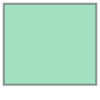

In [6]:
# Use the VMU gdf to define a bounding box that we 
# will use in the SentinelHub query
AOI_coords_ndarray = vmu_polys.total_bounds.round(decimals=2)
AOI_coords = list(AOI_coords_ndarray)
AOI_bbox = BBox(bbox=AOI_coords, crs=CRS.WGS84)
AOI_bbox

In [7]:
# Build SentinelHub query to pull available images in a recent time window
# https://www.sentinel-hub.com/develop/api/ogc/standard-parameters/wcs/
sentinel2_wcs_query = WcsRequest(layer='TRUE-COLOR-S2-L1C',  # Name of SentinelHub layer
                                 bbox=AOI_bbox,
                                 # Time window for query
                                 time=('2021-04-01', date.today()),
                                 # Max cloud cover
                                 maxcc=0.2,
                                 resx='20m', resy='20m',
                                 config=config)

# Get the available dates
sentinel2_dates = sentinel2_wcs_query.get_dates()
sentinel2_dates

C:\Users\ekqo\Miniconda3\envs\earth-analytics-python\lib\site-packages\sentinelhub\data_collections.py:565: SHDeprecationWarning: In the future please specify data_collection parameter, for now taking DataCollection.SENTINEL2_L1C
  'DataCollection.SENTINEL2_L1C', category=SHDeprecationWarning)


[datetime.datetime(2021, 4, 1, 18, 4, 15),
 datetime.datetime(2021, 4, 4, 18, 14, 12),
 datetime.datetime(2021, 4, 6, 18, 4, 17),
 datetime.datetime(2021, 4, 9, 18, 14, 12),
 datetime.datetime(2021, 4, 11, 18, 4, 14),
 datetime.datetime(2021, 4, 14, 18, 14, 10),
 datetime.datetime(2021, 4, 16, 18, 4, 15),
 datetime.datetime(2021, 4, 19, 18, 14, 10),
 datetime.datetime(2021, 4, 21, 18, 4, 15),
 datetime.datetime(2021, 4, 24, 18, 14, 12),
 datetime.datetime(2021, 4, 29, 18, 14, 11),
 datetime.datetime(2021, 5, 1, 18, 4, 16),
 datetime.datetime(2021, 5, 4, 18, 14, 14),
 datetime.datetime(2021, 5, 6, 18, 4, 17),
 datetime.datetime(2021, 5, 9, 18, 14, 14),
 datetime.datetime(2021, 5, 11, 18, 4, 15),
 datetime.datetime(2021, 5, 11, 18, 4, 22),
 datetime.datetime(2021, 5, 14, 18, 14, 15),
 datetime.datetime(2021, 5, 16, 18, 4, 19),
 datetime.datetime(2021, 5, 24, 18, 14, 16)]

In [8]:
# Download the most recent Sentinel 2 dataset
# Location of data download folder
data_folder = os.path.join('sentinelhub_data')

# Build the download WCS request
sentinel2_wcs_download = WcsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox=AOI_bbox,
                                    time=(sentinel2_dates[-1], date.today()),
                                    maxcc=0.9,
                                    # Download a coarse resolution image as Folium
                                    # couldn't handle the native resolution
                                    resx='50m', resy='50m',
                                    data_folder=data_folder,
                                    image_format=MimeType.PNG,
                                    time_difference=datetime.timedelta(
                                        hours=48),
                                    config=config)

# Run the download request
sentinel2_wcs_download.save_data()

# Download list
downloads = sentinel2_wcs_download.get_filename_list()
downloads

['38815a345803a5d96bf7f7ff730997d8\\response.png']

In [9]:
# Add the Sentinel 2 image to the slippy map

# Initialize a slippy map using the McKinley location xy
m = folium.Map(location=[float(mckinley_location.geometry.y[0]), float(
    mckinley_location.geometry.x[0])], zoom_start=12, tiles='OpenStreetMap')

# Overlay raster called img using add_child() function (opacity and bounding box set)
m.add_child(folium.raster_layers.ImageOverlay(os.path.join(data_folder, downloads[0]),
                                              bounds=[[35.59, -109.04], [35.73, -108.88]]))

# Iterate over polygons and add to slippy map with popups
for _, poly in vmu_polys.iterrows():
    poly_geo = gpd.GeoSeries(poly['geometry'])
    poly_geoj = poly_geo.to_json()
    poly_geoj = folium.GeoJson(data=poly_geoj,
                               style_function=lambda x: {'fill': 'false'})
    folium.Popup(poly['ID']).add_to(poly_geoj)
    poly_geoj.add_to(m)

# Add a title to the slippy map
title_html = '''
             <h3 align="center" style="font-size:20px"><b>RGB color composite of \
             the most recent Sentinel 2 data for McKinley Mine with Vegetation \
             Management Units overlaid</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Display map
m

#### Build time series of Sentinel 2 NDVI for the VMU's using SentinelHub Statistical Info (FIS) Service API

In [10]:
# Function to format FIS responses
def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    
    Parameters
    -----------
    fis_data : list
        list of data responses from FIS request

    Returns
    -----------
    output : pandas dataframe
        DF containing formatted results
    
    """
    # Setup columns in df
    columns = ['date', 'min', 'max', 'mean', 'stDev'] # Columns for band ratio result
    clm_columns = ['clm_mean'] # Columns for Cloud Mask
    snw_columns = ['snw_mean'] # Columns for snow detection
    
    # Lists to store results
    data = []
    clm_data = []
    snw_data = []
    
    
    # Loops over multipolygons?
    for fis_response in fis_data:
            
            i = 0
            # Loop over channels
            for channel, channel_stats in fis_response.items():
                
                # Results channel
                if channel == 'C0':
                    for stat in channel_stats:
                        row = [parse_time(stat['date'])]
                        for column in columns[1:]:
                            row.append(stat['basicStats'][column])
                        data.append(row)
                
                # CLM channel
                elif channel == 'C1':
                    for stat in channel_stats:
                        row = [stat['basicStats']['mean']]
                        clm_data.append(row)
                
                # SNW channel
                else: 
                    for stat in channel_stats:
                        row = [stat['basicStats']['mean']]
                        snw_data.append(row)                    
            
            # Convert the lists to df
            data_df = pd.DataFrame(data, columns=columns)
            clm_data_df = pd.DataFrame(clm_data, columns=clm_columns)
            snw_data_df = pd.DataFrame(snw_data, columns=snw_columns)
            
            # Concatenate the df 
            output_df = pd.concat([data_df, clm_data_df, snw_data_df], axis = 1)
            
    return output_df

In [11]:
# Explode multipolygons to polygons to query with FIS request
vmu_polys_exploded = vmu_polys.explode()

# Create empty list to store results for all VMU's
output_list = []

# Loop over VMU's
for index, row in vmu_polys_exploded.iterrows():

    # Process specific VMU's
    if (row.ID == 'OSM VMU 1' or row.ID == 'OSM VMU 6'):

        # Status message
        print('Now processing VMU: ' + str(row.ID))

        # Setup parameters for FIS request
        geometry_list = Geometry(row.geometry, CRS.WGS84)
        time_interval = ('2017-01-01', date.today())
        
        # Custom script to pass to SentinelHub
        ndvi_script = 'return [[(B08 - B04) / (B08 + B04)], CLM, SNW]'

        # Build FIS request
        fis_request = FisRequest(
            data_collection=DataCollection.SENTINEL2_L2A,
            layer='BANDS-S2-L2A',
            geometry_list=[geometry_list],
            time=time_interval,
            resolution='100m',
            custom_url_params={CustomUrlParam.EVALSCRIPT: ndvi_script},
            config=config
        )

        # Run the FIS request
        fis_data = fis_request.get_data()

        # Convert the FIS result to a dataframe
        fis_df = fis_data_to_dataframe(fis_data)

        # Add the VMU to the dataframe
        fis_df['VMU'] = row.ID

        # Append the df to the temporary list
        output_list.append(fis_df)

    else:
        # Status message
        print('skipping this VMU')

# Concatenate the VMU results into a single DF
fis_df_all_raw = pd.concat(output_list, axis=0)
fis_df_all_raw

skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
Now processing VMU: OSM VMU 1
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
Now processing VMU: OSM VMU 6
skipping this VMU
skipping this VMU


,date,min,max,mean,stDev,clm_mean,snw_mean,VMU
0,2021-05-24,0.099955,0.384615,0.163179,0.042533,0.000000,0.000000,OSM VMU 1
1,2021-05-21,-0.047658,0.031409,-0.010051,0.009514,1.000000,24.560538,OSM VMU 1
2,2021-05-19,-0.048801,0.355735,0.129320,0.054233,0.354260,0.000000,OSM VMU 1
3,2021-05-16,0.092635,0.336137,0.150694,0.038755,0.000000,0.000000,OSM VMU 1
4,2021-05-14,0.100951,0.337166,0.155209,0.038379,0.000000,0.000000,OSM VMU 1
...,...,...,...,...,...,...,...,...
533,2017-02-21,0.019572,0.577005,0.141627,0.063661,0.000000,0.000000,OSM VMU 6
534,2017-02-14,-0.024298,0.033762,0.000812,0.006602,1.000000,0.000000,OSM VMU 6
535,2017-02-04,-0.086701,1.000000,0.072358,0.112276,0.000000,18.668058,OSM VMU 6
536,2017-02-01,-0.072752,1.000000,0.014930,0.081513,0.000000,69.684760,OSM VMU 6


In [12]:
# Clean up the FIS results
fis_df_all = fis_df_all_raw.copy(deep=True)

# Convert stats values from objects to float
fis_df_all['min'] = fis_df_all['min'].astype(float, errors = 'raise')
fis_df_all['max'] = fis_df_all['max'].astype(float, errors = 'raise')
fis_df_all['mean'] = fis_df_all['mean'].astype(float, errors = 'raise')
fis_df_all['stDev'] = fis_df_all['stDev'].astype(float, errors = 'raise')
fis_df_all['clm_mean'] = fis_df_all['clm_mean'].astype(float, errors = 'raise')
fis_df_all['snw_mean'] = fis_df_all['snw_mean'].astype(float, errors = 'raise')

# Drop rows with NaN
fis_df_all.dropna(inplace=True)

# Remove cloudy results
fis_df_all.drop(fis_df_all[fis_df_all['clm_mean'] > 0].index, inplace = True)

# Format the date field
fis_df_all['date'] = pd.to_datetime(fis_df_all['date'])

# Average over multipolygon VMU's
fis_df_all = fis_df_all.groupby(['date', 'VMU']).mean()

# Sort by date
fis_df_all.sort_values(['VMU','date'], inplace=True)

# Reset index
fis_df_all.reset_index(inplace=True)
fis_df_all.set_index('date', inplace=True)

fis_df_all

,VMU,min,max,mean,stDev,clm_mean,snw_mean
date,,,,,,,
2017-02-01,OSM VMU 1,-0.065101,0.418167,-0.000307,0.079268,0.0,83.347534
2017-02-04,OSM VMU 1,-0.085023,0.604396,0.025904,0.107958,0.0,48.587444
2017-02-21,OSM VMU 1,0.088458,0.613929,0.156266,0.091894,0.0,0.000000
2017-03-06,OSM VMU 1,-0.043166,0.368078,0.108077,0.074034,0.0,6.114350
2017-03-13,OSM VMU 1,0.076246,0.449008,0.147085,0.059647,0.0,0.000000
...,...,...,...,...,...,...,...
2021-05-06,OSM VMU 6,0.063545,0.303234,0.129877,0.030092,0.0,0.000000
2021-05-11,OSM VMU 6,0.058488,0.295092,0.126078,0.029032,0.0,0.000000
2021-05-14,OSM VMU 6,0.075410,0.324638,0.141178,0.029202,0.0,0.000000


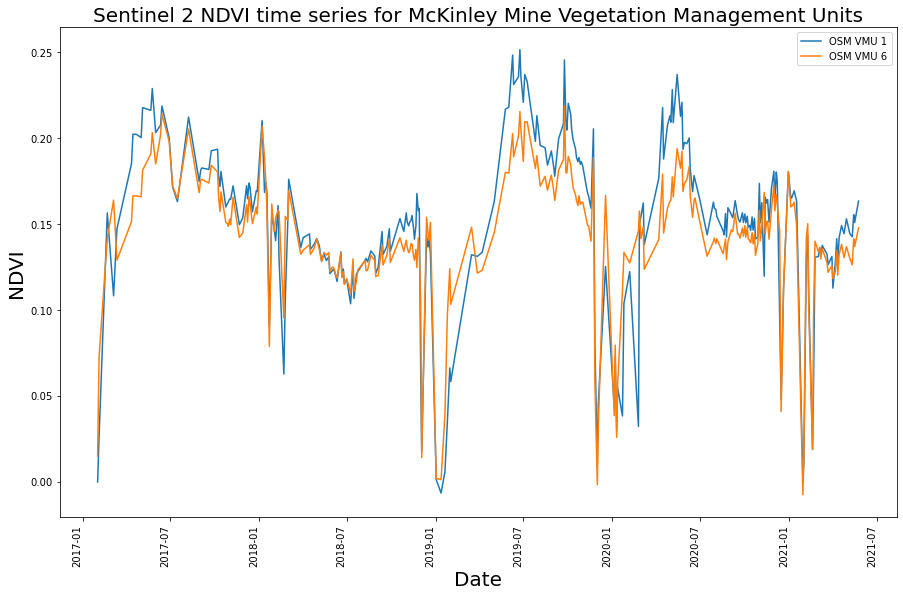

In [13]:
# Create plots
# Setup plot
fig, ax = plt.subplots(figsize=(15, 10))

# Build list of unique sites for legend
sites = fis_df_all.VMU.unique()

fis_df_all.reset_index().groupby('VMU').plot(x='date', y='mean', ax=ax)

# Legend and labels
plt.legend(sites)

plt.xlabel("Date", fontsize=20)
plt.ylabel("NDVI", fontsize=20)

ax.set_title(
    "Sentinel 2 NDVI time series for McKinley Mine Vegetation Management Units", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

## Conclusions and next steps
The example plot of NDVI for two VMU's at McKinley Mine shown above demonstrates seasonal and interannual variations in vegetation growth including periods of green-up in the spring, senescence during the summer to fall, and dormancy over the winter period. The latter periods are also outlined by large troughs in NDVI values related to the presence of snow cover on the ground service and resultant low NDVI values. What's also interesting is some periods of late summer greening are also discernible that are likely related to monsoonal rains. From year to year the cycles in vegetation green-up do change and are likely related to drought periods such as during 2018. Next steps for this work will be to focus on the weather/climate data and building statistical models to interpret the NDVI (and other vegetation index) trends.

One thing I have observed so far from the NDVI time series is that there are not large differences discernible for the different VMU's. This is probably because these units encompass many different stages of seeding and actually are less representative of coherent seeding stages than I first thought. I have been provided with more detailed data that captures the extent and timing of different seeding efforts and my plan will be to use these data as the basis for my analysis rather than the VMU's; these data will permit more focused development of remote sensing time series for areas that have been re-seeded at the same time. This could be used to investigate the trajectory of different stages of seeding.

## References
Reif, M.K. and Theel, H.J. (2017), Remote sensing for restoration ecology: Application for restoring degraded, damaged, transformed, or destroyed ecosystems. Integr Environ Assess Manag, 13: 614-630. https://doi.org/10.1002/ieam.1847

Michele Meroni, Anne Schucknecht, Dominique Fasbender, Felix Rembold, Francesco Fava, Margaux Mauclaire, Deborah Goffner, Luisa M. Di Lucchio, Ugo Leonardi (2017), Remote sensing monitoring of land restoration interventions in semi-arid environments with a before–after control-impact statistical design, International Journal of Applied Earth Observation and Geoinformation, Volume 59, 2017, Pages 42-52, ISSN 0303-2434. https://doi.org/10.1016/j.jag.2017.02.016.

L. Chasmer, T. Baker, S.K. Carey, J. Straker, S. Strilesky, R. Petrone (2018),Monitoring ecosystem reclamation recovery using optical remote sensing: Comparison with field measurements and eddy covariance, Science of The Total Environment, Volume 642, 2018, Pages 436-446, ISSN 0048-9697,https://doi.org/10.1016/j.scitotenv.2018.06.039.

Wei Wang, Rongyuan Liu,Fuping Gan,Ping Zhou,Xiangwen Zhang, andLing Ding (2021) Monitoring and Evaluating Restoration Vegetation Status in Mine Region Using Remote Sensing Data: Case Study in Inner Mongolia, China, Remote Sens. 2021, 13(7), 1350; https://doi.org/10.3390/rs13071350.

Phillip B. McKenna,Alex M. Lechner, Stuart Phinn, and Peter D. Erskine (2020) Remote Sensing of Mine Site Rehabilitation for Ecological Outcomes: A Global Systematic Review, Remote Sens. 2020, 12(21), 3535; https://doi.org/10.3390/rs12213535.

J. Wang, P. M. Rich & K. P. Price (2003) Temporal responses of NDVI to precipitation and temperature in the central Great Plains, USA, International Journal of Remote Sensing, 24:11, 2345-2364, DOI: 10.1080/01431160210154812

Thoma, D.P., Munson, S.M., Irvine, K.M., Witwicki, D.L. and Bunting, E.L. (2016), Semi‐arid vegetation response to antecedent climate and water balance windows. Appl Veg Sci, 19: 413-429. https://doi.org/10.1111/avsc.12232

Copeland, SM, Munson, SM, Bradford, JB, Butterfield, BJ. Influence of climate, post‐treatment weather extremes, and soil factors on vegetation recovery after restoration treatments in the southwestern US. Appl Veg Sci. 2019; 22: 85– 95. https://doi.org/10.1111/avsc.12414

Jie Zhou, Li Jia, Massimo Menenti, Mattijn van Hoek, Jing Lu, Chaolei Zheng, Hao Wua, and Xiaotian Yuan (2021), Characterizing vegetation response to rainfall at multiple temporal scales in the Sahel-Sudano-Guinean region using transfer function analysis, Remote Sensing of Environment, Volume 252, 2021, 112108, ISSN 0034-4257, https://doi.org/10.1016/j.rse.2020.112108.